# Описание проекта
Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. Нам нужно:
1.	Подготовить данные;
2.	Провести исследовательский анализ данных;
3.	Построить и обучить модель.

# 1. Подготовка данных

In [2]:
# Загрузка библиотек и данных
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score 

# Данные загрузим с индексированием по дате
train = pd.read_csv('gold_recovery_train.csv', sep=',' , decimal='.', index_col='date')
test = pd.read_csv('gold_recovery_test.csv', sep=',' , decimal='.', index_col='date')
full = pd.read_csv('gold_recovery_full.csv', sep=',' , decimal='.', index_col='date')

In [3]:
# Копия трейна для вычисления MAE
mae_train = train.copy()

In [4]:
print(full.info())
print(full.describe())
print(test.info())
print(test.describe())
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

Данные имеют пропуски, которые заполним методом соседнего. В задании была ремарка - "Соседние по времени параметры часто похожи". 

In [5]:
full = full.fillna(method='ffill')
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

В тестовой базе отсутствуют признаки содержания основных веществ, соотвтетственно их надо удалить из тренировочной базы, чтобы модель строилась адекватно на тех признаках которые есть в тестовой.
Также в тестовой базе нет целевых признаков rougher.output. recovery и final.output.recovery, которые туда надо добавить из полной базы по индексу.

In [6]:
# Список фичей в тесте
test_features = pd.Series(test.columns.values)
# Список фичей полной выборки
full_features = pd.Series(full.columns.values)
# Список фичей которые надо удалить из трейна
drop_features = full_features[~full_features.isin(test_features)].dropna()
# Удаляем фичи из трейна  
train_drop = train.drop(drop_features, axis = 1)

In [7]:
# Добавляем в тест 2 целевых признака
# Получаем список индексов в тесте
index_test = test.index.tolist()
# Вынимаем строки из full с индексами из теста и вставляем их в тест
targets_full = full.loc[index_test]
test[['rougher.output.recovery', 'final.output.recovery']] = targets_full[['rougher.output.recovery', 'final.output.recovery']]

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётом и значением признака

In [8]:
# Добавим столбец с рассчитанным значением rougher.output.recovery
mae_train['my.rougher.output.recovery'] = 100 *\
((mae_train['rougher.output.concentrate_au'] * \
  (mae_train['rougher.input.feed_au'] - mae_train['rougher.output.tail_au']))\
 /(mae_train['rougher.input.feed_au'] * \
   (mae_train['rougher.output.concentrate_au'] - mae_train['rougher.output.tail_au'])))  

In [9]:
# Формируем для удобства фрейм из двух нкжных столбцов и удаляем пропуски
mae_train = mae_train[['my.rougher.output.recovery','rougher.output.recovery']]  
mae_train.dropna()

,my.rougher.output.recovery,rougher.output.recovery
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794
...,...,...
2018-08-18 06:59:59,89.574376,89.574376
2018-08-18 07:59:59,87.724007,87.724007
2018-08-18 08:59:59,88.890579,88.890579


In [10]:
mae_train['MAE'] = abs(mae_train['rougher.output.recovery'] - mae_train['my.rougher.output.recovery'])
print('MAE:', mae_train['MAE'].mean())

MAE: 9.444891926100695e-15


### Вывод
Эффективность обогащения рассчитана правильно, потому как MAE по рассчитанным и существующим значчениям стремится к 0

# 2. Анализ данных

## 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

rougher.input.feed_au                     7.144279
rougher.output.concentrate_au            17.337662
primary_cleaner.output.concentrate_au    29.041786
final.output.concentrate_au              39.321631
dtype: float64

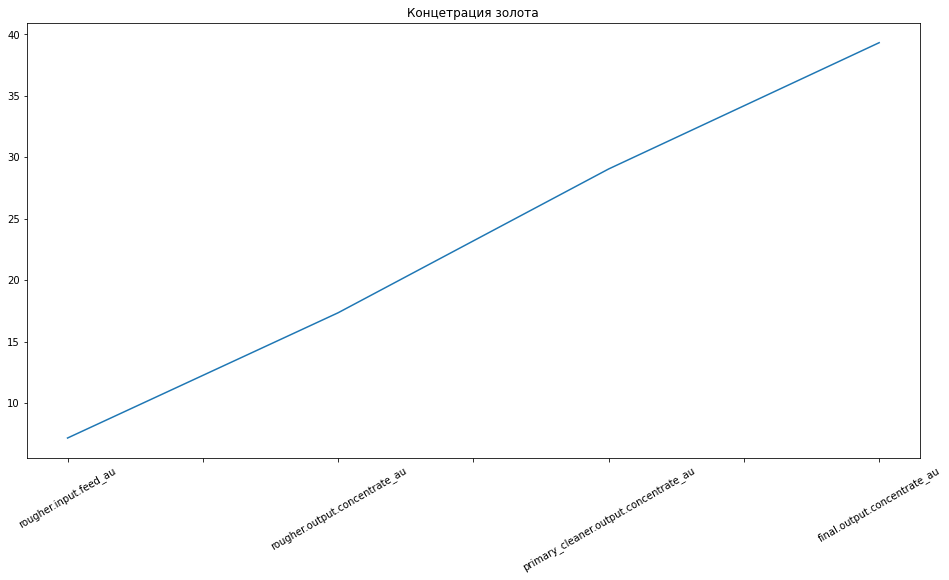

In [21]:
au = train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
display(au.mean())
au.mean().plot(title = 'Концетрация золота', kind='line', rot=30, figsize=(16,8))

rougher.input.feed_ag                     7.803825
rougher.output.concentrate_ag            10.541930
primary_cleaner.output.concentrate_ag     7.390585
final.output.concentrate_ag               4.699066
dtype: float64

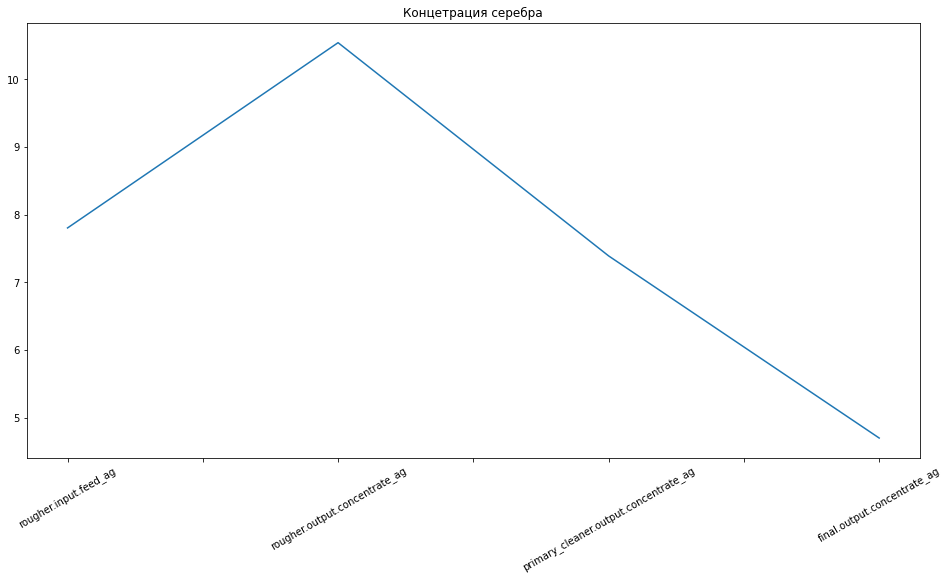

In [22]:
ag = train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
display(ag.mean())
ag.mean().plot(title = 'Концетрация серебра', kind='line', rot=30, figsize=(16,8))

rougher.input.feed_pb                    3.188803
rougher.output.concentrate_pb            6.861249
primary_cleaner.output.concentrate_pb    8.493673
final.output.concentrate_pb              9.080638
dtype: float64

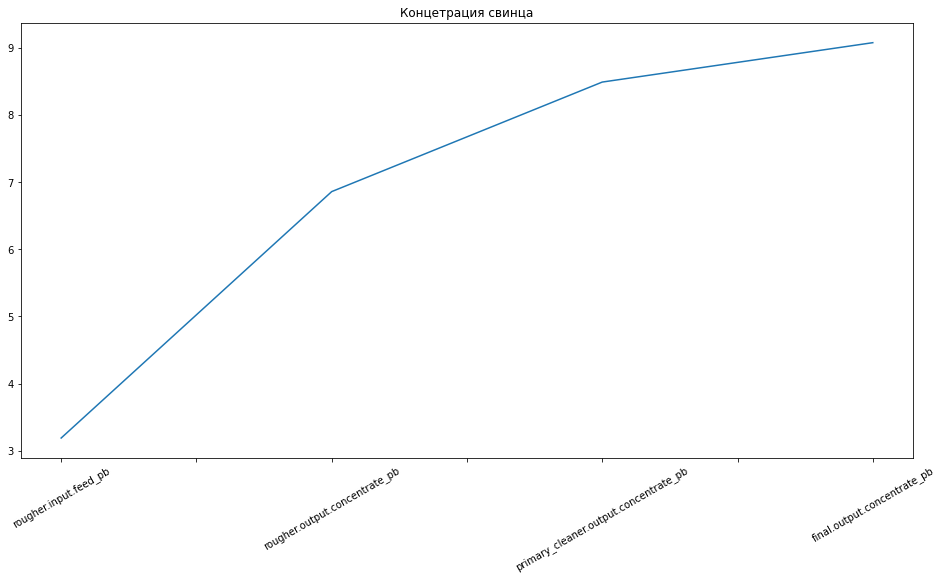

In [23]:
pb = train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
display(pb.mean())
pb.mean().plot(title = 'Концетрация свинца', kind='line', rot=30, figsize=(16,8))

## Выводы
Концеттрация золота и свинца в сырье в процессе очистки повышается, а концетрация серебра повышается после флотации, но падает при дальнейшей очистки. Вывод: на первой и второй очистке много серебра уходит в хвосты.  

## 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [24]:
print('Среднее распределение на трейне: ', train['rougher.input.feed_au'].mean())
print('Среднее распределение на тесте: ', test['rougher.input.feed_au'].mean())
print('Дисперсия: ', train['rougher.input.feed_au'].var())
print('Дисперсия ', test['rougher.input.feed_au'].var())

Среднее распределение на трейне:  7.14427893593878
Среднее распределение на тесте:  8.702055592956915
Дисперсия:  9.157064926181947
Дисперсия  7.868493070460929


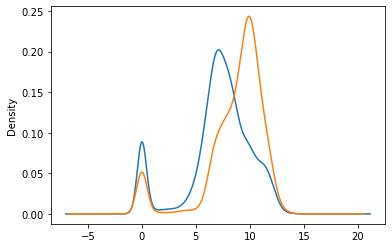

In [25]:
def compare(feature):
    train[feature].plot.kde()
    test[feature].plot.kde()
    plt.legend
compare('rougher.input.feed_au')

## Выводы
Распределения всё равно похожи. Они оба унимодальны, их средние и дисперсии очень близки друг к другу. Так что можно сказать, что распределения очень близки друг к другу, поэтому должно всё быть корректно.

## 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

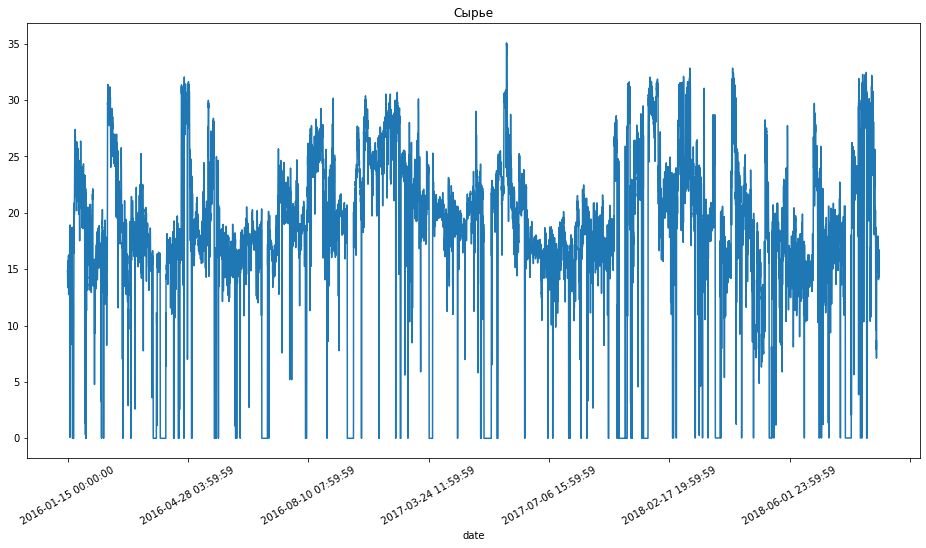

In [29]:
train['rougher.input.feed_all_metall'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_au'] + train['rougher.input.feed_pb']
train['rougher.input.feed_all_metall'].plot(title = 'Сырье', kind='line', rot=30, figsize=(16,8))

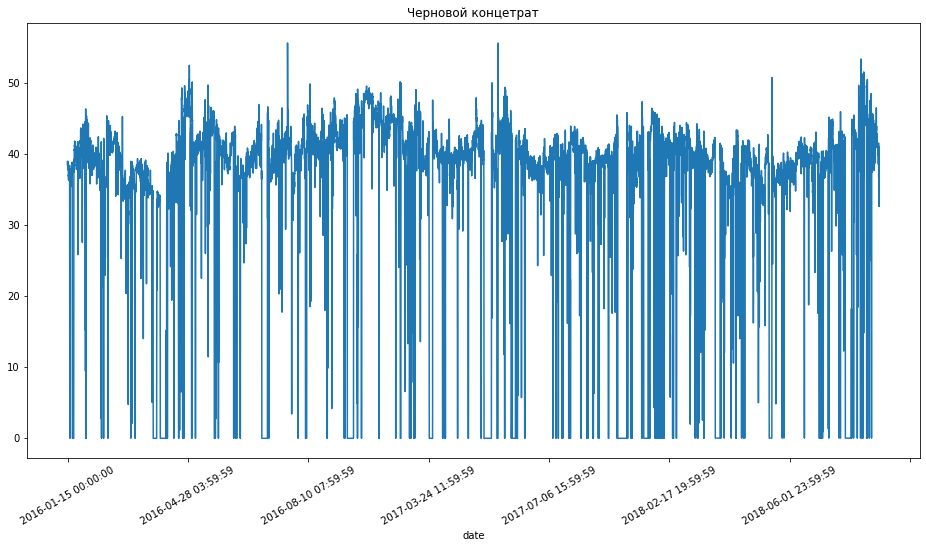

In [30]:
train['rougher.output.concentrate_all_metall'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_pb']
train['rougher.output.concentrate_all_metall'].plot(title = 'Черновой концетрат', kind='line', rot=30, figsize=(16,8))

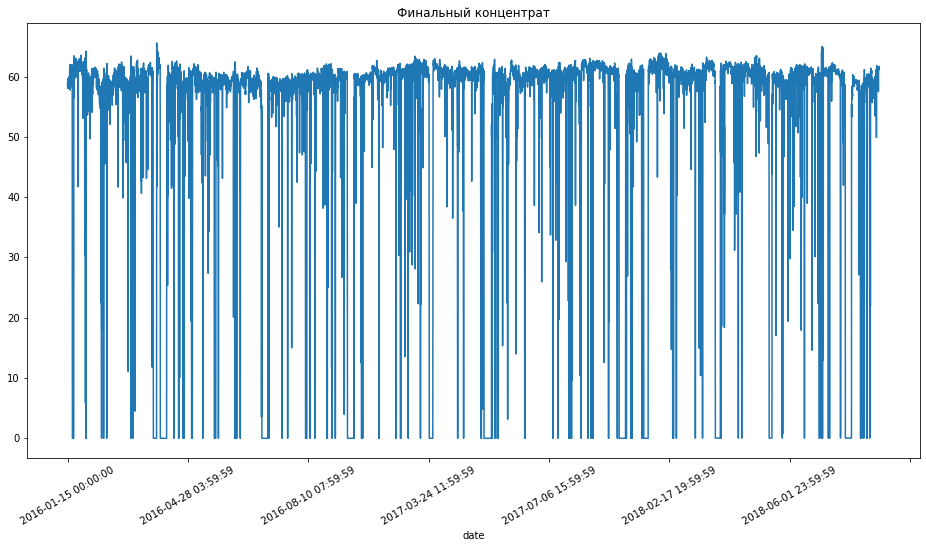

In [31]:
train['final.output.concentrate_all_metall'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_au'] + train['final.output.concentrate_pb']
train['final.output.concentrate_all_metall'].plot(title = 'Финальный концентрат', kind='line', rot=30, figsize=(16,8))

На всех 3 стадях существую нулевые значения, которые являются аномальными. Т.е. руда не содержит металлов. Такие аномалии надо удалить из тренировочной выборки для повышения качества модели. Выбросы в большую сторону отсутствуют

In [32]:
train = train[train['rougher.input.feed_all_metall'] != 0]
train = train[train['rougher.output.concentrate_all_metall'] != 0]
train = train[train['final.output.concentrate_all_metall'] != 0]

# 3. Построение модели

Фунция для вычисления sMAPE

In [33]:
def smape (t, p): # T - целевой признак, P - предсказание
    return 100/len(t) * np.sum(2 * np.abs(t - p) / (np.abs(t) + np.abs(p)))

Подготовка данных

In [34]:
# Удаляем фичи из трейна  
features = train.drop(drop_features, axis = 1) # удаляем фичи, не используемые в тестовой выборке
features = features.iloc[:,0:52] # удаляем искусственно добавленные фичи
# Целевые признаки
rougher_t = train['rougher.output.recovery'] # целевой признак для грубой очистки
final_t = train['final.output.recovery'] # целевой признак для финальной очистки

In [35]:
features.shape

(15128, 52)

### 3.1. Линейная регрессия

In [36]:
# Линейная регрессия для грубой очистки
model = LinearRegression()
model.fit(features, rougher_t) 
rougher_p = model.predict(features)

In [37]:
# Линейная регрессия для финальной очистки
model = LinearRegression()
model.fit(features, final_t) 
final_p = model.predict(features)

In [38]:
# Вычисление итоговой sMAPE
total_smape = 0.25 * float(smape(rougher_t, rougher_p)) + 0.75 * float(smape(final_t, final_p))
print('Итоговая sMAPE:', total_smape)

Итоговая sMAPE: 8.824383945840612


### 3.2.  Дерево решений

In [39]:
best_model = None
best_result_1 = 10000
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    model.fit(features, rougher_t) 
    rougher_p = model.predict(features)
    result = smape(rougher_t, rougher_p)
    if result < best_result_1:
        best_model = model
        best_result_1 = result
        best_depth = depth
print("sMAPE наилучшей модели на валидационной выборке:", best_result_1, "Количество деревьев:", best_depth)

sMAPE наилучшей модели на валидационной выборке: 5.5257325371113355 Количество деревьев: 5


In [40]:
best_model = None
best_result_2 = 10000
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    model.fit(features, final_t) 
    final_p = model.predict(features)
    result = smape(final_t, final_p)
    if result < best_result_2:
        best_model = model
        best_result_2 = result
        best_depth = depth
print("sMAPE наилучшей модели на валидационной выборке:", best_result_2, "Количество деревьев:", best_depth)

sMAPE наилучшей модели на валидационной выборке: 8.626634349378989 Количество деревьев: 5


In [41]:
# Вычисление итоговой sMAPE
total_smape = 0.25 * best_result_1 + 0.75 * best_result_2
print('Итоговая sMAPE:', total_smape)

Итоговая sMAPE: 7.851408896312075


### 3.3 Случайный лес

In [42]:
best_model = None
best_result_1 = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=42, n_estimators=est, max_depth=depth)
        model.fit(features, rougher_t) 
        rougher_p = model.predict(features)
        result = smape(rougher_t, rougher_p)
        if result < best_result_1:
            best_model = model
            best_result_1 = result
            best_est = est
            best_depth = depth
print("sMAPE наилучшей модели на валидационной выборке:", best_result_1, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

sMAPE наилучшей модели на валидационной выборке: 3.6202267640299812 Количество деревьев: 50 Максимальная глубина: 10


In [43]:
best_model = None
best_result_2 = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features, final_t) 
        final_p = model.predict(features)
        result = smape(final_t, final_p)
        if result < best_result_2:
            best_model = model
            best_result_2 = result
            best_est = est
            best_depth = depth
print("sMAPE наилучшей модели на валидационной выборке:", best_result_2, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

sMAPE наилучшей модели на валидационной выборке: 6.320727139885403 Количество деревьев: 40 Максимальная глубина: 10


In [44]:
# Вычисление итоговой sMAPE
total_smape = 0.25 * best_result_1 + 0.75 * best_result_2
print('Итоговая sMAPE:', total_smape)

Итоговая sMAPE: 5.645602045921548


Наилучшей моделью является Случайный лес. Проверим ее на тестовой выборке

In [45]:
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1) # удаляем таргеты 
# Целевые признаки
test_rougher_t = test['rougher.output.recovery'] # целевой признак для грубой очистки
test_final_t = test['final.output.recovery'] # целевой признак для финальной очистки

In [46]:
# Для грубой очистки
model = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=10)
model.fit(features, rougher_t) 
test_rougher_p = model.predict(features_test)       

In [47]:
# Для финальной очистки
model = RandomForestRegressor(random_state=42, n_estimators=40, max_depth=10)
model.fit(features, final_t) 
test_final_p = model.predict(features_test)  

In [48]:
# Вычисление итоговой sMAPE
total_smape = 0.25 * float(smape(test_rougher_t, test_rougher_p)) + 0.75 * float(smape(test_final_t, test_final_p))
print('Итоговая sMAPE:', total_smape)

Итоговая sMAPE: 13.822829631056765


Сравним полученный результат с константной моделью

In [49]:
# Обозначаем константную модель как среднее
const_rouger = rougher_t.median()
const_final = final_t.median()

In [50]:
# Вычисление итоговой sMAPE
total_smape = 0.25 * float(smape(test_rougher_t, const_rouger)) + 0.75 * float(smape(test_final_t, const_final))
print('Итоговая sMAPE:', total_smape)

Итоговая sMAPE: 11.883803624130028


Получается, что предсказание мы делаем чуть лучше константной модели

# Вывод
Наилучшей моделью является Случайный лес с итоговой характеристикой sMAPE = 7.83% 

Качество модели очень низкое. С предоставленными данными улучшить его можно, но не намного.  
Для дальнейшего улучшения качества моделирования возможно надо:  
* Оценить качество данных на входе на соответствие физике (правдиво ли всё)
* Запросить дополнительные параметры, которые можно включить в модель 
* Более углубленно апроанадизировать гиперпараметры можделей